In [0]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding



In [0]:
# data_folder = './twitter-datasets/'
data_folder = './'


# Reading the data
positive_path = os.path.join(data_folder,'train_pos_full.txt')
negative_path = os.path.join(data_folder,'train_neg_full.txt')

In [0]:
lines_positive = [line.rstrip('\n') for line in open(positive_path)]
lines_negative = [line.rstrip('\n') for line in open(negative_path)]

# Data preparation

## Create DF

In [0]:
# Create dataFrame from positive tweets and give them value 1 as a sentiment
data_pos = pd.DataFrame({"tweets": lines_positive,
                      "sentiment":np.ones(len(lines_positive))
                      })

# Create dataFrame from negative tweets and give them value 0 as a sentiment
data_neg = pd.DataFrame({"tweets": lines_negative,
                      "sentiment":np.zeros(len(lines_negative))
                      })
# Concat both of them
data = pd.concat([data_pos,data_neg],axis=0).reset_index().drop(columns=['index'])

# Shuffle everything so that we don't have all the positives in one cluster and all the negatives in another
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,sentiment,tweets
0,1.0,<user> <user> i saw my winston is a better nin...
1,0.0,christians & money ( 1 a biblically-based guid...
2,1.0,worst student but at least im a good teacher #...
3,0.0,goodmorning tweeps - you know the only bad thi...
4,1.0,plumbing issues ... need i say more ? . please...


## Clean up the text

In [0]:
# Remove <anything> from tweets.
data['tweets'].replace(regex=True,inplace=True,to_replace=r'<.*?>',value=r'')
data.head()

,sentiment,tweets
0,1.0,i saw my winston is a better ninja than your...
1,0.0,christians & money ( 1 a biblically-based guid...
2,1.0,worst student but at least im a good teacher #...
3,0.0,goodmorning tweeps - you know the only bad thi...
4,1.0,plumbing issues ... need i say more ? . please...


In [0]:
X = data['tweets'].tolist()
y =  data['sentiment'].tolist()

## Use tokenizer
### From words to numbers

In [0]:
# map words to numbers
vocab_size = 100000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)

In [0]:
num_words = len(tokenizer.word_index)
num_words

507952

In [0]:
data['length'] = data['tweets'].str.split().apply(len)
max_tokens = data['length'].max()
max_tokens = int(max_tokens/2)

X = np.array(sequence.pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_tokens, padding='pre'))

# Split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### From numbers to words

In [0]:
def numbers_to_string(number_array, tokenizer):
    
    ''' 
    Transforms tokens to words
    :param number_array: The numbers array to transform
    :param tokenizer: The tokenizer used

    :return: the original text
    :rtype: String
    '''
        
    indices = tokenizer.word_index
    # Create a dict that mapes numbers to their respective words
    inverse_map = dict(zip(indices.values(), indices.keys()))
        
    # Maps the numbers back to words.
    words = []
    for number in number_array:
        if number != 0: # !=0 is to remove the padding
            words.append(inverse_map[number])
    
    # Concatenate all words.
    text = " ".join(words)

    return text

In [0]:
numbers_to_string(X_train[0],tokenizer)

"i wanna go to a concert where's summer argh"

# Neural Network

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=max_tokens))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Saves the model after each epoch to study overfitting and optimal epochs
checkpointer = ModelCheckpoint('weights.{epoch:01d}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

epochs = 10

history = model.fit(X_train, y_train, batch_size=1024, verbose=1, validation_split=0.2, epochs=epochs, callbacks=[checkpointer])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 63, 32)            16254464  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 63, 128)           20608     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 31, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 31, 64)            49216     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 64)            0         
__________

In [0]:
# from keras.models import load_model   

# accuracies = []
# for i in range(1,epochs+1):
#   path = 'weights.'+str(i)+'.hdf5'
#   model = load_model(path)
#   result = model.evaluate(X_test, y_test, verbose=0)
#   accuracies.append(result[1])
  
# accuracies

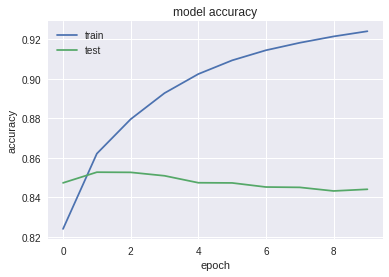

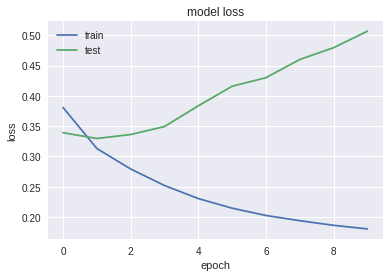

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()